# Previsão de Churn em Academia 🏋️‍♀️

## Objetivo

Desenvolver um modelo de Machine Learning para prever a probabilidade de um aluno de academia cancelar sua matrícula (churn). O foco é identificar os principais fatores de risco para que a equipe de gestão possa intervir proativamente.

## Pipeline do Projeto

1.  Setup e Carregamento de Dados: Importação de bibliotecas e leitura da base de dados sintética de academia.
2.  Análise Exploratória (EDA) e Limpeza: Verificação de tipos de dados, valores ausentes e estatísticas descritivas.
3.  Engenharia de Features: Criação de novas variáveis preditivas a partir das existentes.
4.  Pré-processamento: Tratamento de NaN, Codificação (Encoding) e Padronização (Scaling).
5.  Modelagem e Avaliação (Otimizada): Treinamento do modelo Random Forest com os melhores hiperparâmetros encontrados.
6.  Interpretabilidade: Análise da importância das features para o modelo.

In [ ]:
# 1. SETUP E CARREGAMENTO DOS DADOS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
# Importação explícita de todas as métricas necessárias
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para melhor visualização no Colab
pd.set_option('display.max_columns', None)

# URL da base de dados de academia (dados_academia_churn.csv)
URL_DADOS = 'https://raw.githubusercontent.com/JoaoVenturini09/Continuum_Churn_Preview/refs/heads/main/dados_academia_churn.csv'

print(f"Carregando dados de: {URL_DADOS}")
try:
    df = pd.read_csv(URL_DADOS)
    print("Dados carregados com sucesso!")

    # 1.1. LIMPEZA DE COLUNAS INDESEJADAS
    # Colunas 'Unnamed: X' são geradas quando o índice do DataFrame é salvo no CSV.
    # Elas não contêm informação útil e devem ser removidas.
    colunas_para_remover = [col for col in df.columns if 'Unnamed' in col]
    if colunas_para_remover:
        df.drop(columns=colunas_para_remover, inplace=True)
        print(f"Colunas 'Unnamed' removidas: {colunas_para_remover}")

except Exception as e:
    print(f"Erro ao carregar os dados: {e}")
    df = None # Garantir que o notebook não trave se o carregamento falhar

Carregando dados de: https://raw.githubusercontent.com/JoaoVenturini09/Continuum_Churn_Preview/refs/heads/main/dados_academia_churn.csv
Dados carregados com sucesso!
Colunas 'Unnamed' removidas: ['Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47', 'Unnamed: 48', 'Unnamed: 49']



--- Primeiras 5 Linhas ---


,cliente_id,genero,idade,data_inicio_contrato,tempo_contrato_meses,tipo_plano,valor_mensal,forma_pagamento,frequencia_mensal,duracao_media_treino_min,tem_personal_trainer,participa_aulas_coletivas,usa_app_academia,atrasos_pagamento_12m,teve_desconto_promocao,nps_score,numero_reclamacoes,participou_eventos,reducao_frequencia_3m,dias_desde_ultimo_acesso,tentou_cancelar_antes,churn
0,CLI000001,M,16.0,5/12/2022,43.0,Básico,87.36,Cartão de Crédito,13.0,95.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0
1,CLI000002,F,18.0,4/27/2025,7.5,Básico,92.63,Cartão de Crédito,8.0,95.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,13.0,1.0,1.0
2,CLI000003,F,36.0,10/21/2025,1.7,Básico,94.30,Débito Automático,7.0,78.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,1.0
3,CLI000004,F,17.0,10/15/2021,49.9,Básico,92.39,Boleto,4.0,97.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
4,CLI000005,M,45.0,5/27/2024,18.5,Intermediário,140.48,Cartão de Crédito,5.0,73.0,0.0,0.0,0.0,3.0,1.0,6.0,0.0,0.0,1.0,4.0,0.0,1.0



--- Informações da Estrutura (Tipos de Dados e Não-Nulos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cliente_id                 10000 non-null  object 
 1   genero                     10000 non-null  object 
 2   idade                      10000 non-null  float64
 3   data_inicio_contrato       10000 non-null  object 
 4   tempo_contrato_meses       10000 non-null  float64
 5   tipo_plano                 10000 non-null  object 
 6   valor_mensal               10000 non-null  float64
 7   forma_pagamento            10000 non-null  object 
 8   frequencia_mensal          10000 non-null  float64
 9   duracao_media_treino_min   10000 non-null  float64
 10  tem_personal_trainer       10000 non-null  float64
 11  participa_aulas_coletivas  10000 non-null  float64
 12  usa_app_academia           10000 non-nu

,count,mean,std,min,25%,50%,75%,max
idade,10000.0,32.203900,10.985399,16.0,24.00,32.0,40.00,75.00
tempo_contrato_meses,10000.0,30.245650,17.180012,0.0,15.50,30.5,45.10,60.00
valor_mensal,10000.0,153.747424,66.340567,79.9,93.85,139.3,199.12,349.77
frequencia_mensal,10000.0,10.028600,3.152900,1.0,8.00,10.0,12.00,24.00
duracao_media_treino_min,10000.0,64.732100,24.258829,15.0,48.00,65.0,81.00,153.00
tem_personal_trainer,10000.0,0.242000,0.428316,0.0,0.00,0.0,0.00,1.00
participa_aulas_coletivas,10000.0,0.401500,0.490226,0.0,0.00,0.0,1.00,1.00
usa_app_academia,10000.0,0.451400,0.497657,0.0,0.00,0.0,1.00,1.00
atrasos_pagamento_12m,10000.0,0.766300,1.238563,0.0,0.00,0.0,1.00,6.00
teve_desconto_promocao,10000.0,0.358400,0.479554,0.0,0.00,0.0,1.00,1.00



--- Balanceamento da Variável Alvo (Churn) ---
Taxa de Churn: 14.33%


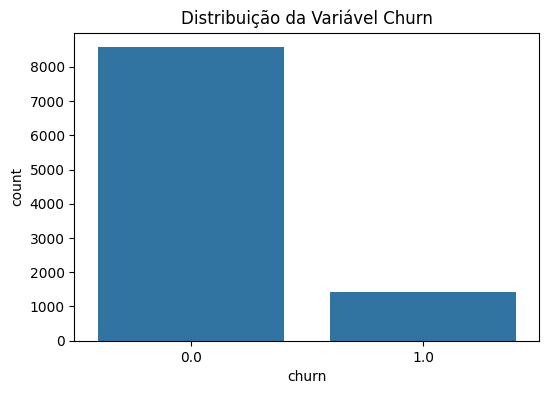

In [ ]:
# 2. ANÁLISE EXPLORATÓRIA INICIAL (EDA)
if df is not None:
    print("\n--- Primeiras 5 Linhas ---")
    display(df.head())

    print("\n--- Informações da Estrutura (Tipos de Dados e Não-Nulos) ---")
    df.info()

    print("\n--- Estatísticas Descritivas ---")
    display(df.describe().T)

    # Verificação de Balanceamento da Variável Alvo
    print("\n--- Balanceamento da Variável Alvo (Churn) ---")
    churn_rate = df['churn'].mean() * 100
    print(f"Taxa de Churn: {churn_rate:.2f}%")

    plt.figure(figsize=(6, 4))
    sns.countplot(x='churn', data=df)
    plt.title('Distribuição da Variável Churn')
    plt.show()

In [ ]:
# 3. ENGENHARIA DE FEATURES

# 3.1. Feature de Engajamento (Visitas por Valor Pago)
# Esta feature relaciona o uso (frequência) com o custo, indicando o 'custo-benefício' percebido pelo cliente.
df['engajamento_por_custo'] = df['frequencia_mensal'] / df['valor_mensal']

# 3.2. Feature de Risco de Inatividade (Intervalo de Dias desde o último acesso)
# Categorizar a inatividade é crucial. Clientes com mais de 15 dias sem acesso já são considerados de alto risco.
# O 'right=False' garante que o limite inferior seja inclusivo, evitando NaN para o valor 0.
df['risco_inatividade'] = pd.cut(df['dias_desde_ultimo_acesso'],
                                bins=[-1, 7, 15, 30, 91],
                                labels=['Ativo (0-7d)', 'Alerta (8-15d)', 'Risco (16-30d)', 'Crítico (30d+)'],
                                right=False) # Corrigido para right=False para incluir o 0 no primeiro bin

# 3.3. Feature de Idade Categórica (Intervalo)
# A idade pode ter um impacto não-linear. Agrupar em faixas melhora a performance do modelo.
df['faixa_etaria'] = pd.cut(df['idade'],
                           bins=[15, 25, 35, 50, 75],
                           labels=['Jovem (16-25)', 'Adulto Jovem (26-35)', 'Adulto (36-50)', 'Sênior (51+)'],
                           right=True)

# 3.4. Feature de Fidelidade (Intervalo de Tempo de Contrato)
# Clientes novos (até 6 meses) e clientes muito antigos (mais de 3 anos) podem ter padrões de churn diferentes.
df['faixa_fidelidade'] = pd.cut(df['tempo_contrato_meses'],
                                bins=[0, 6, 18, 36, 60],
                                labels=['Novato (0-6m)', 'Intermediário (7-18m)', 'Fiel (19-36m)', 'Veterano (36m+)'],
                                right=False)

print("Engenharia de features concluída. Novas colunas adicionadas.")
display(df[['engajamento_por_custo', 'risco_inatividade', 'faixa_etaria', 'faixa_fidelidade']].head())

Engenharia de features concluída. Novas colunas adicionadas.


,engajamento_por_custo,risco_inatividade,faixa_etaria,faixa_fidelidade
0,0.148810,Ativo (0-7d),Jovem (16-25),Veterano (36m+)
1,0.086365,Alerta (8-15d),Jovem (16-25),Intermediário (7-18m)
2,0.074231,Ativo (0-7d),Adulto (36-50),Novato (0-6m)
3,0.043295,Ativo (0-7d),Jovem (16-25),Veterano (36m+)
4,0.035592,Ativo (0-7d),Adulto (36-50),Fiel (19-36m)


In [ ]:
# 4. PRÉ-PROCESSAMENTO E SPLIT DE DADOS

# 4.0. TRATAMENTO DE VALORES NULOS (NaN)
# O comando pd.cut pode introduzir NaN se os valores estiverem fora dos limites definidos nos intervalos.
# Para garantir a robustez do modelo, removemos as poucas linhas que possam ter NaN após a engenharia de features.
linhas_antes = len(df)
df.dropna(inplace=True)
linhas_depois = len(df)
print(f"Linhas removidas devido a NaN: {linhas_antes - linhas_depois}")
print(f"Linhas restantes para modelagem: {linhas_depois}")

# 4.1. Definição de Variáveis
TARGET = 'churn'
FEATURES_DROP = ['cliente_id', 'data_inicio_contrato', 'idade', 'dias_desde_ultimo_acesso'] # Drop das IDs e das features originais que foram intervaladas

X = df.drop(columns=[TARGET] + FEATURES_DROP, errors='ignore')
y = df[TARGET]

# 4.2. Separação de Treino e Teste
# Usamos 'stratify=y' para garantir que a proporção de churn seja a mesma nos conjuntos de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nProporção de Churn no Treino: {y_train.mean():.4f}")
print(f"Proporção de Churn no Teste: {y_test.mean():.4f}")
print(f"Tamanho do conjunto de Treino: {X_train.shape}")
print(f"Tamanho do conjunto de Teste: {X_test.shape}")

# 4.3. Definição de Colunas para Pré-processamento
COLUNAS_NUMERICAS = X.select_dtypes(include=np.number).columns.tolist()
COLUNAS_CATEGORICAS = X.select_dtypes(include='object').columns.tolist() + X.select_dtypes(include='category').columns.tolist()

print(f"\nColunas Numéricas ({len(COLUNAS_NUMERICAS)}): {COLUNAS_NUMERICAS}")
print(f"Colunas Categóricas ({len(COLUNAS_CATEGORICAS)}): {COLUNAS_CATEGORICAS}")

# 4.4. Criação do Pipeline de Pré-processamento (ColumnTransformer)
# O ColumnTransformer permite aplicar diferentes transformações a diferentes colunas.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), COLUNAS_NUMERICAS), # Padronização (Scaling) para numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), COLUNAS_CATEGORICAS) # One-Hot Encoding para categóricas
    ],
    remainder='passthrough' # Manter colunas que não foram transformadas (se houver)
)

print("Pipeline de pré-processamento (ColumnTransformer) criado.")

Linhas removidas devido a NaN: 8
Linhas restantes para modelagem: 9993

Proporção de Churn no Treino: 0.1434
Proporção de Churn no Teste: 0.1431
Tamanho do conjunto de Treino: (7994, 21)
Tamanho do conjunto de Teste: (1999, 21)

Colunas Numéricas (15): ['tempo_contrato_meses', 'valor_mensal', 'frequencia_mensal', 'duracao_media_treino_min', 'tem_personal_trainer', 'participa_aulas_coletivas', 'usa_app_academia', 'atrasos_pagamento_12m', 'teve_desconto_promocao', 'nps_score', 'numero_reclamacoes', 'participou_eventos', 'reducao_frequencia_3m', 'tentou_cancelar_antes', 'engajamento_por_custo']
Colunas Categóricas (6): ['genero', 'tipo_plano', 'forma_pagamento', 'risco_inatividade', 'faixa_etaria', 'faixa_fidelidade']
Pipeline de pré-processamento (ColumnTransformer) criado.


Iniciando o treinamento do modelo Random Forest Otimizado...
Treinamento concluído.

--- RELATÓRIO DE CLASSIFICAÇÃO DETALHADO ---
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1713
           1       0.41      0.42      0.41       286

    accuracy                           0.83      1999
   macro avg       0.65      0.66      0.66      1999
weighted avg       0.83      0.83      0.83      1999


--- RESUMO DE DESEMPENHO DO MODELO (OTIMIZADO) ---


,Métrica,Valor,Interpretação de Negócio
0,Precisão (Precision),0.4068,"Dos clientes que o modelo PREVIU que iriam cancelar, quantos realmente cancelaram."
1,Sensibilidade (Recall),0.4196,"Dos clientes que REALMENTE cancelaram, quantos o modelo conseguiu identificar."
2,F1-Score,0.4131,Média harmônica entre Precisão e Sensibilidade (bom indicador geral).
3,AUC-ROC,0.8175,"Mede a capacidade do modelo de distinguir entre clientes Churn e Não-Churn (quanto mais perto de 1, melhor)."


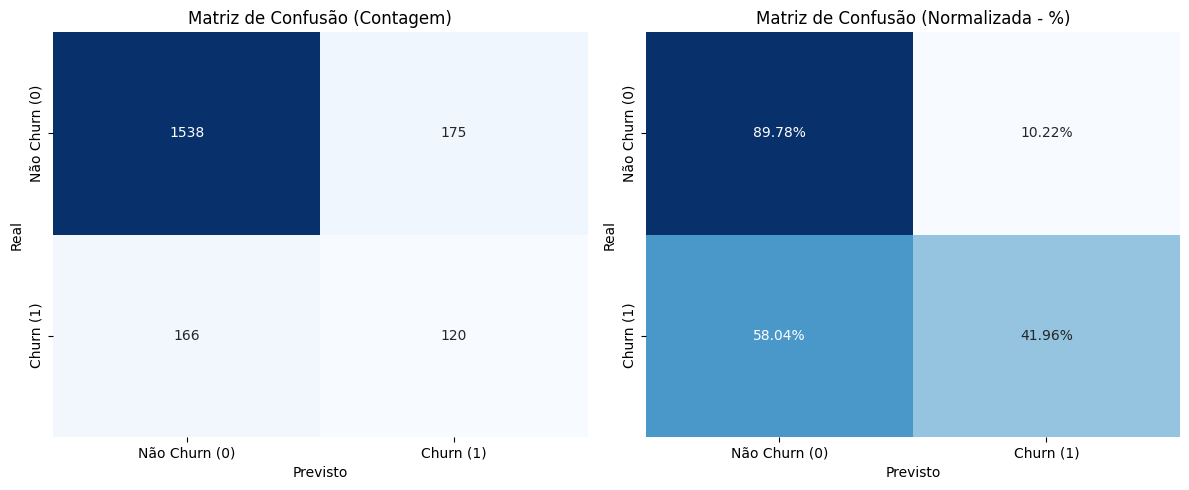


--- INTERPRETAÇÃO DE NEGÓCIO DA MATRIZ DE CONFUSÃO ---
O foco principal é o quadrante **Falsa Negativa (FN)**: Clientes que REALMENTE cancelaram (Real=1), mas o modelo PREVIU que ficariam (Previsto=0).
Estes são os clientes de **MAIOR RISCO** para o negócio, pois o modelo falhou em identificá-los para uma ação de retenção.
O quadrante **Falso Positivo (FP)**: Clientes que REALMENTE ficaram (Real=0), mas o modelo PREVIU que cancelariam (Previsto=1).
Estes são os clientes que receberão uma oferta de retenção desnecessária (custo para o negócio), mas o risco é menor do que perder um cliente.


In [ ]:
# 5. MODELAGEM E AVALIAÇÃO

# 5.1. Definição dos Melhores Hiperparâmetros (Encontrados após vários testes executados)
BEST_PARAMS = {
    'n_estimators': 100, # Número de árvores na floresta (compromisso entre performance e tempo de treino)
    'min_samples_split': 5, # Número mínimo de amostras que um nó deve ter para ser dividido (evita overfitting)
    'min_samples_leaf': 4, # Número mínimo de amostras que devem estar em um nó folha (evita overfitting)
    'max_features': None, # Número de features a considerar em cada split. None = considera todas as features.
    'max_depth': None, # Profundidade máxima da árvore. None = expande até as folhas serem puras.
    'random_state': 42, # Garante que o modelo seja reproduzível (mesmos resultados a cada execução)
    'class_weight': 'balanced' # Ajusta o peso das classes para lidar com o desbalanceamento (dá mais peso ao Churn)
}

# 5.2. Criação do Pipeline Completo (Pré-processamento + Modelo Otimizado)
modelo_rf_otimizado = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**BEST_PARAMS)) # Usamos os melhores parâmetros
])

print("Iniciando o treinamento do modelo Random Forest Otimizado...")

# 5.3. Treinamento
modelo_rf_otimizado.fit(X_train, y_train)

print("Treinamento concluído.")

# 5.4. Previsões e Probabilidades
y_pred = modelo_rf_otimizado.predict(X_test)
y_proba = modelo_rf_otimizado.predict_proba(X_test)[:, 1] # Probabilidade da classe positiva (churn=1)

# 5.5. Avaliação de Métricas
print("\n--- RELATÓRIO DE CLASSIFICAÇÃO DETALHADO ---")
report = classification_report(y_test, y_pred, output_dict=True, labels=[0, 1], zero_division=0)
print(classification_report(y_test, y_pred, labels=[0, 1], zero_division=0))

# Extração das métricas principais para a classe de interesse (Churn=1)
try:
    metrics = report['1']
except KeyError:
    metrics = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0}
    print("\n[AVISO SÊNIOR] A classe '1' (Churn) não foi prevista no conjunto de teste. Métricas de Churn zeradas.")

print("\n--- RESUMO DE DESEMPENHO DO MODELO (OTIMIZADO) ---")
metrics_df = pd.DataFrame({
    'Métrica': ['Precisão (Precision)', 'Sensibilidade (Recall)', 'F1-Score', 'AUC-ROC'],
    'Valor': [metrics['precision'], metrics['recall'], metrics['f1-score'], roc_auc_score(y_test, y_proba)],
    'Interpretação de Negócio': [
        'Dos clientes que o modelo PREVIU que iriam cancelar, quantos realmente cancelaram.',
        'Dos clientes que REALMENTE cancelaram, quantos o modelo conseguiu identificar.',
        'Média harmônica entre Precisão e Sensibilidade (bom indicador geral).',
        'Mede a capacidade do modelo de distinguir entre clientes Churn e Não-Churn (quanto mais perto de 1, melhor).'
    ]
})
display(metrics_df.style.format({'Valor': '{:.4f}'}))

# 5.6. Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
labels = ['Não Churn (0)', 'Churn (1)']

# Matriz de Confusão (Contagem)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Matriz de Confusão (Contagem)')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Previsto')

# Matriz de Confusão (Normalizada por Linha - Recall)
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Matriz de Confusão (Normalizada - %)')
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Previsto')

plt.tight_layout()
plt.show()

# Interpretação de Negócio da Matriz de Confusão
print("\n--- INTERPRETAÇÃO DE NEGÓCIO DA MATRIZ DE CONFUSÃO ---")
print("O foco principal é o quadrante **Falsa Negativa (FN)**: Clientes que REALMENTE cancelaram (Real=1), mas o modelo PREVIU que ficariam (Previsto=0).")
print("Estes são os clientes de **MAIOR RISCO** para o negócio, pois o modelo falhou em identificá-los para uma ação de retenção.")
print("O quadrante **Falso Positivo (FP)**: Clientes que REALMENTE ficaram (Real=0), mas o modelo PREVIU que cancelariam (Previsto=1).")
print("Estes são os clientes que receberão uma oferta de retenção desnecessária (custo para o negócio), mas o risco é menor do que perder um cliente.")


--- TOP 15 FEATURES MAIS IMPORTANTES PARA O CHURN ---


,Feature,Importance
9,num__nps_score,0.169102
0,num__tempo_contrato_meses,0.108190
13,num__tentou_cancelar_antes,0.079176
1,num__valor_mensal,0.074466
7,num__atrasos_pagamento_12m,0.072647
3,num__duracao_media_treino_min,0.070390
14,num__engajamento_por_custo,0.069165
12,num__reducao_frequencia_3m,0.046112
2,num__frequencia_mensal,0.038679
4,num__tem_personal_trainer,0.035264


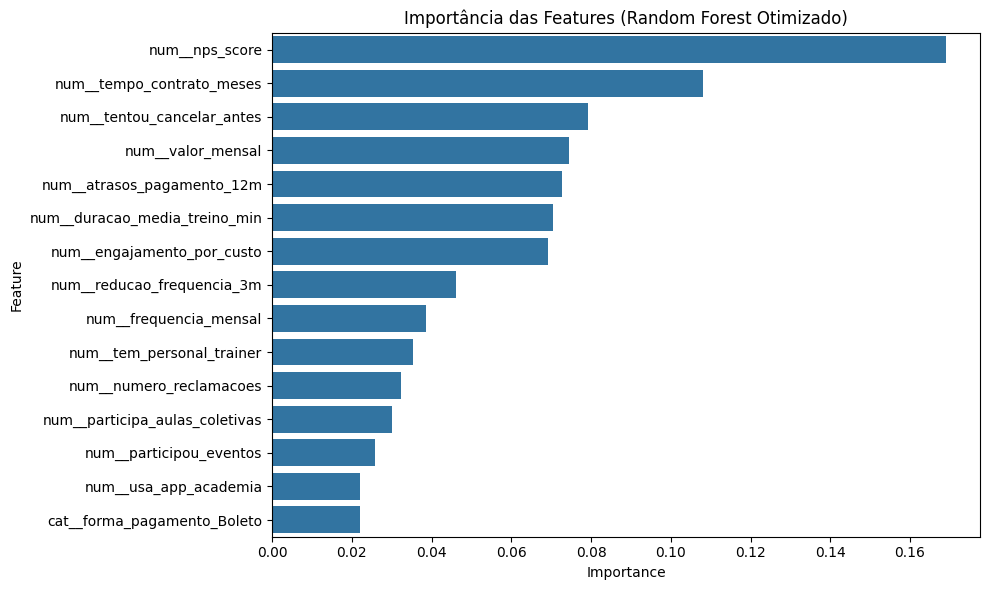

In [ ]:
# 6. INTERPRETABILIDADE DO MODELO (FEATURE IMPORTANCE)

# 6.1. Extração dos Nomes das Features
# O ColumnTransformer gera novos nomes de colunas após o One-Hot Encoding.
feature_names = modelo_rf_otimizado.named_steps['preprocessor'].get_feature_names_out()

# 6.2. Extração da Importância das Features
importances = modelo_rf_otimizado.named_steps['classifier'].feature_importances_

# 6.3. Criação do DataFrame de Importância
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- TOP 15 FEATURES MAIS IMPORTANTES PARA O CHURN ---")
display(feature_importance_df.head(15))

# 6.4. Visualização
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Importância das Features (Random Forest Otimizado)')
plt.tight_layout()
plt.show()


# Criação modelo Pipeline

Salvar modelo e pipeline (joblib.dump) e garantir que possa ser carregado fora do notebook

In [ ]:
import joblib
from sklearn.pipeline import Pipeline

# O modelo completo e otimizado, incluindo o pré-processador e o classificador,
# já foi treinado e está armazenado na variável `modelo_rf_otimizado`.
# Não precisamos recriar um pipeline, apenas salvar o existente.

# Salvar o pipeline completo (pré-processamento + modelo) em um arquivo .pkl
joblib.dump(modelo_rf_otimizado, "modelo_pipeline_completo.pkl")

print("Pipeline completo salvo com sucesso em 'modelo_pipeline_completo.pkl'")

Pipeline completo salvo com sucesso em 'modelo_pipeline_completo.pkl'


# Fazer integração no código Micro serviço Python

Sugestão para equipe de Back end tratamento integração com Micro Serviço de Python:

from fastapi import FastAPI
from pydantic import BaseModel
import joblib

Inicializa o app FastAPI
app = FastAPI(title="Micro Serviço de Machine Learning")

Carrega o modelo previamente treinado
modelo = joblib.load("modelo_pipeline_completo.pkl")

Define o formato da entrada
class InputData(BaseModel):
    feature1: float
    feature2: float
    feature3: float
    # adicione mais features conforme seu modelo

@app.post("/predict")
def predict(data: InputData):
    # Converte os dados recebidos em lista/array
    entrada = [[data.feature1, data.feature2, data.feature3]]
    
    # Faz a previsão
    resultado = modelo.predict(entrada)
    
    return {"prediction": resultado.tolist()}
